#### Relationship Method of Admission with Student Success or Dropout Risks 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('spQ3.csv')
df.head()

,Application mode,Application order,Course,Previous qualification,Previous qualification (grade),Admission grade,Target_status
0,17,5,171,1,122.0,127.3,1
1,15,1,9254,1,160.0,142.5,2
2,1,5,9070,1,122.0,124.8,1
3,17,2,9773,1,122.0,119.6,2
4,39,1,8014,1,100.0,141.5,2


In [5]:
df.shape

(4424, 7)

In [ ]:
# Set labels 1 = Dropout, 2 = Enrolled, 3 = Graduate
target_map = {1:"Dropout", 2:"Enrolled", 3:"Graduate"}
df["Status"] = df["Target_status"].map(target_map)

sns.set(style="whitegrid")


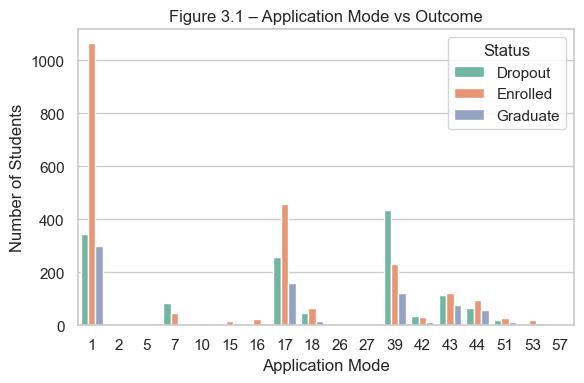

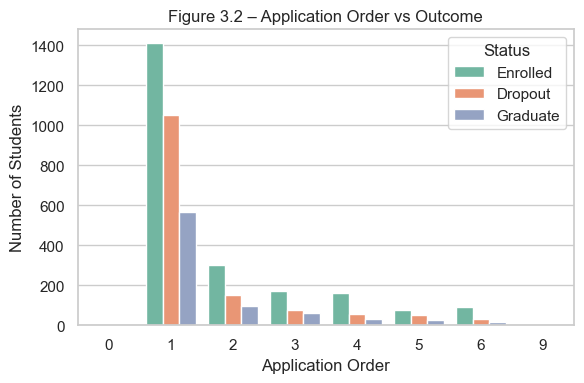

C:\Users\shafi\AppData\Local\Temp\ipykernel_18320\3796633499.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Status", y="Admission grade", palette="Set3")


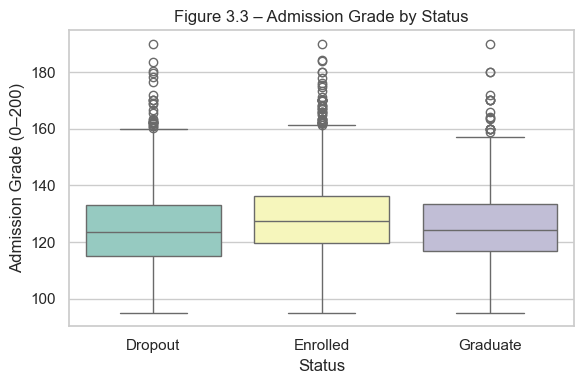

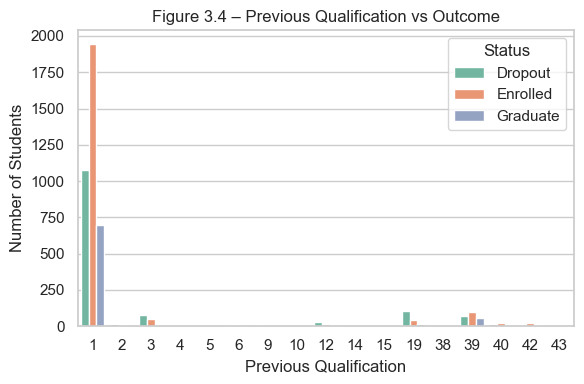

In [26]:
# Figure 3.1 – Application Mode vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Application mode", hue="Status", palette="Set2")
plt.title("Figure 3.1 – Application Mode vs Outcome")
plt.xlabel("Application Mode"); plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout(); plt.show()

# Figure 3.2 – Application Order vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Application order", hue="Status", palette="Set2")
plt.title("Figure 3.2 – Application Order vs Outcome")
plt.xlabel("Application Order"); plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout(); plt.show()

# Figure 3.3 – Admission Grade by Status
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Status", y="Admission grade", palette="Set3")
plt.title("Figure 3.3 – Admission Grade by Status")
plt.xlabel("Status"); plt.ylabel("Admission Grade (0–200)")
plt.tight_layout(); plt.show()

# Figure 3.4 – Previous Qualification vs Outcome
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Previous qualification", hue="Status", palette="Set2")
plt.title("Figure 3.4 – Previous Qualification vs Outcome")
plt.xlabel("Previous Qualification"); plt.ylabel("Number of Students")
plt.legend(title="Status")
plt.tight_layout(); plt.show()

